# Super-Resolution Convolutional Neural Network training

Here in this jupyter notebook, we will train a super-resolution convolutional neural network (SRCNN), to create high-resolution bed Digital Elevation Model(DEM) from a low-resolution DEM.
In addition to that, we use additional correlated inputs that can also tell us something about the bed topography.

<img src="http://yuml.me/diagram/scruffy;dir:LR/class/[BEDMAP2 (1000m)] -&gt; [SRCNN model], [REMA (200m)] -&gt; [SRCNN model], [MEASURES Ice Flow Velocity (450m)] -&gt; [SRCNN model], [SRCNN model] -&gt; [High res bed DEM (250m)]" alt="3 input FSRCNN model"/>

## 0. Setup libraries

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import quilt
import skimage.transform
%matplotlib inline

import keras
from keras import backend as K
from keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, Lambda
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from livelossplot import PlotLossesKeras

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', K.tf.__version__)

Using TensorFlow backend.


Python       : 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
Numpy        : 1.14.5
Keras        : 2.2.2
Tensorflow   : 1.10.1


In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
K.tf.set_random_seed(seed=seed)

## 1. Load data

In [3]:
hash = '09cc7e2ae732f3ff09f86cb18e359fdde7fbdbdf7293b5b3c20ad83788dcef19'
quilt.install(package='weiji14/deepbedmap/model/train', hash=hash, force=False)
pkg = quilt.load(pkginfo='weiji14/deepbedmap', hash=hash)

weiji14/deepbedmap/model/train already installed.


Overwrite? (y/n)  y


Fragments already downloaded


In [4]:
W1_data = pkg.model.train.W1_data()  #miscellaneous data REMA
W2_data = pkg.model.train.W2_data()  #miscellaneous data MEASURES Ice Flow
X_data = pkg.model.train.X_data()  #low resolution BEDMAP2
Y_data = pkg.model.train.Y_data()  #high resolution groundtruth
#W1_data = np.load(file="model/train/W1_data.npy")
#W2_data = np.load(file="model/train/W2_data.npy")
#X_data = np.load(file="model/train/X_data.npy")
#Y_data = np.load(file="model/train/Y_data.npy")
print(W1_data.shape, W2_data.shape, X_data.shape, Y_data.shape)

(371, 40, 40, 1) (371, 17, 17, 1) (371, 8, 8, 1) (371, 32, 32, 1)


## 2. Architect model

Fast SRCNN model based on [Dong et al. 2016](https://arxiv.org/abs/1608.00367).
Original Matlab and Caffe code from paper is [here](http://mmlab.ie.cuhk.edu.hk/projects/FSRCNN.html).
Keras implementation below takes some hints from https://github.com/GeorgeSeif/FSRCNN-Keras.

![FSRCNN model visualization](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/391726/x2.png)

In [5]:
def fsrcnn_model(input1_shape:tuple=(8,8,1), input2_shape:tuple=(40,40,1), input3_shape:tuple=(17,17,1), scaling:int=4) -> keras.engine.training.Model:
    """
    Modified Fast Super Resolution Convolutional Neural Network (FSRCNN) model.
    Takes in two (correlated) inputs instead of just one.
    Architected using Keras, with a tensorflow backend.
    
    Takes an input low-resolution image of shape (8,8,1)
    and other relevant input images of shape (40,40,1), (17,17,1).
    
    Outputs a high-resolution image of shape (64,64,1).
    I.e. An 8x scaling factor.
    """
    
    ## Input images
    inp1 = Input(shape=input1_shape)  #low resolution image
    assert(inp1.shape.ndims == 4) #needs to be shape like (?,8,8,1) for 8x8 grid
    inp2 = Input(shape=input2_shape)  #other image (e.g. REMA)
    assert(inp2.shape.ndims == 4) #needs to be shape like (?,40,40,1) for 40x40 grid
    inp3 = Input(shape=input3_shape)  #other image (MEASURES Ice Flow)
    assert(inp3.shape.ndims == 4) #needs to be shape like (?,17,17,1) for 17x17 grid
    
    
    ## Pass image through convolution layers
    ## FSRCNN(56,12,4), FSRCNN(d,s,m) where d=feature dimension/filters, s=shrinking filters, m=mapping depth
    
    # 0 part
    # Resize inputs to right scale
    size = np.array(input1_shape[:2])*scaling  #i.e. [8,8] * 4 = [32,32]
    resize_func = lambda images: K.tf.image.resize_nearest_neighbor(images=images, size=size)
    inp1r = Lambda(function=resize_func, name=f'nn_resize1')(inp1)
    inp2r = Lambda(function=resize_func, name=f'nn_resize2')(inp2)
    inp3r = Lambda(function=resize_func, name=f'nn_resize3')(inp3)
    
    # Concatenate all inputs
    #SEE https://distill.pub/2016/deconv-checkerboard/
    X = Concatenate()([inp1r, inp2r, inp3r])  #Concatenate all the inputs together
    
    # 1st part
    # feature extraction
    X = Conv2D(filters=56, kernel_size=(5,5), strides=(1,1), padding='same', name='conv1')(X)
    X = PReLU()(X)
    
    # 2nd part
    # shrinking
    X = Conv2D(filters=12, kernel_size=(1,1), strides=(1,1), padding='same', name='conv2')(X)
    X = PReLU()(X)
    
    # non-linear mapping 
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv22')(X)
    X = PReLU()(X)
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv23')(X)
    X = PReLU()(X)
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv24')(X)
    X = PReLU()(X)
    X = Conv2D(filters=12, kernel_size=(3,3), strides=(1,1), padding='same', name='conv25')(X)
    X = PReLU()(X)
    
    # expanding
    X = Conv2D(filters=56, kernel_size=(1,1), strides=(1,1), padding='same', name='conv26')(X)
    X = PReLU()(X)
    
    # 3rd part
    # deconvolution
    outp = Conv2DTranspose(filters=1, kernel_size=(9,9), strides=(1,1), padding='same', name='conv3')(X)
    
    # Create model with input low-res image and output prediction
    model = Model(inputs=[inp1, inp2, inp3], outputs=[outp])
   
    return model

In [6]:
# Peak Signal-Noise Ratio (PSNR) metric https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
def psnr(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis=-1)
    return 20 * K.log(2**16/K.sqrt(mse))  #setting MAX_I as 2^16, i.e. max for int16

In [7]:
model = fsrcnn_model()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mse, metrics=[psnr])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 17, 17, 1)    0                                            
__________________________________________________________________________________________________
nn_resize1 (Lambda)             (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
nn_resize2

## 3. Train model

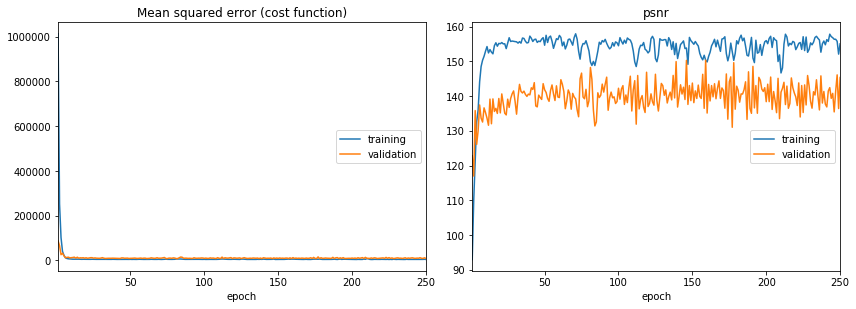

In [8]:
tensorboard = keras.callbacks.TensorBoard(log_dir='model/logs', histogram_freq=1, write_graph=True)
model.fit(x=[X_data, W1_data, W2_data], y=Y_data, verbose=1, validation_split=0.05, batch_size=32,
          epochs=250, callbacks=[tensorboard, PlotLossesKeras(max_cols=2)])

In [9]:
raise ValueError('temp')

ValueError: temp

## 4. Evaluate model

In [ ]:
Y_hat = model.predict(x=[X_data, W1_data, W2_data], verbose=1)
print(Y_hat.shape, Y_hat.dtype)

In [ ]:
for i in range(5):
    try:
        id = random.randrange(0,len(X_data))
        print(id, X_data[id].shape)
        
        X_cube = skimage.transform.rescale(image=X_data[id].astype(np.int32), scale=4, order=3, mode='reflect', anti_aliasing=True, multichannel=False)
        
        fig, axarr = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(15,15))
        axarr[0, 0].imshow(X_data[id][:,:,0], aspect='equal')  #low resolution original
        axarr[0, 1].imshow(X_cube[:,:,0], aspect='equal')      #bicubic interpolation
        axarr[0, 2].imshow(W1_data[id][:,:,0], aspect='equal')  #REMA surface DEM
        axarr[0, 3].imshow(Y_hat[id][:,:,0], aspect='equal')   #srcnn prediction
        axarr[0, 4].imshow(Y_data[id][:,:,0], aspect='equal')  #groundtruth
        
        axarr[0, 0].set_title('BEDMAP2')
        axarr[0, 1].set_title('Bicubic')
        axarr[0, 1].set_xlabel(f'PSNR: {round(skimage.measure.compare_psnr(im_true=Y_data[id][:,:,0].astype(np.int32), im_test=X_cube[:,:,0].astype(np.int32)), 2)}')
        axarr[0, 2].set_title('REMA')
        axarr[0, 3].set_xlabel(f'PSNR: {round(skimage.measure.compare_psnr(im_true=Y_data[id][:,:,0].astype(np.int32), im_test=Y_hat[id][:,:,0].astype(np.int32)),2)}')
        axarr[0, 3].set_title('SRCNN')
        axarr[0, 4].set_title('Groundtruth')
        
        plt.show()
    except TypeError:
        pass